# Model Results

## Introduction

I've engineered 4 distinct RAG models. For indexing, I've carefully designed 4 methods (source/index_utils.py) to organize and structure the "1300 Towards Data Science Medium Articles" dataset, making it easy to search and find specific articles. For retrieval, I've built strong systems (source/rag_model.py) that uses RAG to find and provide relevant parts of articles. I've also made sure to break down the articles into smaller sections in a smart way to ensure that the returned fragments have just the right amount of information. In order to properly compare models i prepared some evaluation tools (source/eval_utils.py). I utilized [LlamaIndex](https://www.llamaindex.ai/) to implement these models effectively. In this notebook I present the results and comparison between them to assess their performance and effectiveness. 


Below I imported essential libraries aswell predefined by me Rag Models.

In [1]:
# imports
import sys
import os
import pandas as pd
sys.path.append(os.getcwd()[:-10]+'\\source')
from rag_model import RagModel, SentenceWindowRagModel, AutomergeRagModel, ChatRagModel
from eval_utils import get_prebuilt_trulens_recorder, score_histogram, score_boxplot
from trulens_eval import Tru

✅ In Answer Relevance, input prompt will be set to __record__.main_input or `Select.RecordInput` .
✅ In Answer Relevance, input response will be set to __record__.main_output or `Select.RecordOutput` .
✅ In Context Relevance, input prompt will be set to __record__.main_input or `Select.RecordInput` .
✅ In Context Relevance, input response will be set to __record__.app.query.rets.source_nodes[:].node.text .
✅ In Groundedness, input source will be set to __record__.app.query.rets.source_nodes[:].node.text .
✅ In Groundedness, input statement will be set to __record__.main_output or `Select.RecordOutput` .


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


I made some questions based on the 1300 Medium Articles Dataset. I wil use them later for models evaluation

In [3]:
eval_questions = ['What is Word2vec?', 'Databricks: How to Save Data Frames as CSV Files on Your Local Computer?', 'What is What-If Tool?', 'Transfer Learning?', 'Neural Turing Machines?',
                  'Do human beings have the most densely packed set of neurons?', 'What are 4 main types of hackathons?', ' What is the problem of Reinforcement Learning', 'When to use PCA?'
                  'What does ARIMA explains?', 'What does Microsoft Power BI offer?', 'What is the primary reason for Tableau popularity?', 'What does Linear regression models?']

In [4]:
sample_question = 'What is neuron according to the Neuron Doctrine'

For the sample question above model should return a fragment from this paragraph:

**Paragraph**: According to the Neuron Doctrine, the neuron is the fundamental structural and functional unit of the brain. Neurons pass information to other neurons in the form of electrical impulses from dendrites to axon via cell body. This requires maintenance of ionic potential difference between inside and outside which takes up around 20 % of the daily glucose consumption of the body. Myelin sheath aides in fast lossless long-distance communication of electrical impulses spikes by wrapping around the axon. This happens by a mechanism called Saltatory Conduction where the spike hops from one Node of Ranvier (myelin-sheath gaps) to the other. This show how beautifully the brain encompasses the concept of lossless signal transmission. Connections between two neurons is called a synapse which can be of electrical and chemical nature both. Electrical for fast transmission for functions such as reflex, chemical for learning and memory. Firing the neurons is an energy-intensive process hence all neurons are not firing at the same time. This signals that there might be an amazing energy optimising scheduling algorithm embedded in the brain. The concept of weights in the neural networks probably was inspired from the concept of Hebbian Plasticity which is often understood as Cells that fire together wire together. There are various important components of the brain and each of them are connected with each other. The most interesting one for me is Thalamus which is like a base station, takes the input signals from our sensory organs and then passes it onto the cerebral cortex which is often called the star of the show. The brain is great when it comes to resource management. Many of the tasks that the brain performs are done unconsciously because of which we can multitask something like massive parallel computing. There are many sub networks of neurons that also forms part of a bigger network and connected to smaller networks as well. When it comes to learning and memory brain has different ways in place.


In [5]:
# read data
df = pd.read_csv(os.getcwd()[:-10]+'\\data\\medium.csv')

For testing RAG models I used [TruLens-Eval](https://pypi.org/project/trulens-eval/). TruLens-Eval is used for evaluating performance of various LLM experiments.

In [6]:
tru = Tru()

🦑 Tru initialized with db url sqlite:///default.sqlite .
🛑 Secret keys may be written to the database. See the `database_redact_keys` option of Tru` to prevent this.


Before discussing the results, it would be beneficial to outline the criteria I will use for rating the model. I used so called _'The RAG Triad'_:

- __Groundedness__: Assesses how well the generated answers are supported by the content of the documents.

- __Context Relevance__: evaluates the relevance of retrieved context by analyzing the structure of serialized records, ensuring that each chunk of context is pertinent to the input query to prevent hallucinations.

- __Answer Relevance__: examines the final response's relevance to the original query, ensuring that it effectively addresses the user's input, thus providing helpful and pertinent answers without straying from the intended topic.


It is also important to consider latency and total cost. Optimizing these factors reduces waiting times and costs, respectively.

![Rag Triad](../images/Rag_Triad.jpg)


## Initial Model

This model is quite simple. It follows the basic RAG pipeline (diagram below). At the beginning, text from a pandas dataframe is parsed. After that, based on the chunk size, the text is split, embedded, and stored as vectors using [Vector Store Index](https://docs.llamaindex.ai/en/stable/module_guides/indexing/vector_store_index/). Retrieval involves the engine receiving a query and searching the index for the k most similar embeddings, returning the response.

<p align="center">
  <img src="../images/basic_rag_pipeline.png" alt="Rag pipeline">
</p>


It offers many space for optimization taking parameters such as:
- __top_k__: number of embeding, which model returns
- __similiarity_cutoff__: Used to remove nodes that are below a similarity score threshold
- __chunk_size__: Determines the size of text segments for embedding.
- __chunk_overlap__: Specifies the overlap between adjacent chunks.


Optimizing these parameters can enhance the efficiency of the model. After conducting several tests, I decided to utilize the parameters specified in the instance object below, as they provide an optimal balance between fragment length and content richness. Further improvements to this model could involve adjusting hyperparameters, for example, by implementing techniques outlined in [this article](https://www.llamaindex.ai/blog/evaluating-the-ideal-chunk-size-for-a-rag-system-using-llamaindex-6207e5d3fec5). However, it's important to note that finding the optimal hyperparameters would require a broader tuning range for each parameter than presented in this article. Such task would demand significant computing power.



In [7]:
import nest_asyncio
nest_asyncio.apply()
model1 = RagModel(df, top_k=12, similiarity_cutoff=0.7, chunk_size=256, chunk_overlap=64)
await model1.create_engine()

Model's response to the prompt shows that It succesfully retrieved wanted fragment.

In [8]:
str(model1.engine.query(sample_question))

'The neuron, according to the Neuron Doctrine, is considered the fundamental structural and functional unit of the brain.'

In [9]:
tru.reset_database()

In [10]:
tru_recorder = get_prebuilt_trulens_recorder(model1.engine,
                                             app_id="Direct Query Engine")

In [ ]:
with tru_recorder as recording:
    for question in eval_questions:
        response = model1.engine.query(question)

In [18]:
records1, feedback = tru.get_records_and_feedback(app_ids=[])

Thie recorda Ddataframe shows many important information about the model. In every row you can see the query prompt and model's output aswell the essential evaluation metrics such as Context Relevance, Groundedness, Answer Relevance. We can optimize the model using these metrics. Additionaly, latency and total cost are shown, which are also important.

In [19]:
records1.head()

,app_id,app_json,type,record_id,input,output,tags,record_json,cost_json,perf_json,ts,Answer Relevance,Context Relevance,Groundedness,Answer Relevance_calls,Context Relevance_calls,Groundedness_calls,latency,total_tokens,total_cost
0,Direct Query Engine,"{""tru_class_info"": {""name"": ""TruLlama"", ""modul...",RetrieverQueryEngine(llama_index.core.query_en...,record_hash_e7205ddf96a7900ece2023b14a169eb7,"""What is Word2vec?""","""Word2vec is a two-layer neural network that p...",-,"{""record_id"": ""record_hash_e7205ddf96a7900ece2...","{""n_requests"": 2, ""n_successful_requests"": 2, ...","{""start_time"": ""2024-04-09T00:45:12.286371"", ""...",2024-04-09T00:45:19.366352,1.0,0.550000,1.0,"[{'args': {'prompt': 'What is Word2vec?', 'res...","[{'args': {'prompt': 'What is Word2vec?', 'res...","[{'args': {'source': '""it was the worst of tim...",7,3066,0.004632
1,Direct Query Engine,"{""tru_class_info"": {""name"": ""TruLlama"", ""modul...",RetrieverQueryEngine(llama_index.core.query_en...,record_hash_f91f1c0fa44c00ae205f9ff3a699fa57,"""Databricks: How to Save Data Frames as CSV Fi...","""To save data frames from Databricks into CSV ...",-,"{""record_id"": ""record_hash_f91f1c0fa44c00ae205...","{""n_requests"": 2, ""n_successful_requests"": 2, ...","{""start_time"": ""2024-04-09T00:45:19.916258"", ""...",2024-04-09T00:45:27.584021,0.9,0.325000,0.2,[{'args': {'prompt': 'Databricks: How to Save ...,[{'args': {'prompt': 'Databricks: How to Save ...,[{'args': {'source': 'Databricks: How to Save ...,7,3006,0.004547
2,Direct Query Engine,"{""tru_class_info"": {""name"": ""TruLlama"", ""modul...",RetrieverQueryEngine(llama_index.core.query_en...,record_hash_c64231de62d79df57637b79353da638b,"""What is What-If Tool?""","""The What-If Tool is a tool designed for speed...",-,"{""record_id"": ""record_hash_c64231de62d79df5763...","{""n_requests"": 2, ""n_successful_requests"": 2, ...","{""start_time"": ""2024-04-09T00:45:28.165727"", ""...",2024-04-09T00:45:35.952241,1.0,0.575000,1.0,"[{'args': {'prompt': 'What is What-If Tool?', ...","[{'args': {'prompt': 'What is What-If Tool?', ...",[{'args': {'source': 'and here’s a question fo...,7,3247,0.004897
3,Direct Query Engine,"{""tru_class_info"": {""name"": ""TruLlama"", ""modul...",RetrieverQueryEngine(llama_index.core.query_en...,record_hash_b4750f474e1add8f299ceff95f7cd9d8,"""Transfer Learning?""","""Transfer Learning is a method that involves u...",-,"{""record_id"": ""record_hash_b4750f474e1add8f299...","{""n_requests"": 2, ""n_successful_requests"": 2, ...","{""start_time"": ""2024-04-09T00:45:36.582711"", ""...",2024-04-09T00:45:44.784726,1.0,0.816667,1.0,"[{'args': {'prompt': 'Transfer Learning?', 're...","[{'args': {'prompt': 'Transfer Learning?', 're...","[{'args': {'source': 'model, such as Google’s ...",8,2964,0.004486
4,Direct Query Engine,"{""tru_class_info"": {""name"": ""TruLlama"", ""modul...",RetrieverQueryEngine(llama_index.core.query_en...,record_hash_9197c2c7fb063e17069bf4bd72bb479d,"""Neural Turing Machines?""","""Neural Turing Machines are designed with an a...",-,"{""record_id"": ""record_hash_9197c2c7fb063e17069...","{""n_requests"": 2, ""n_successful_requests"": 2, ...","{""start_time"": ""2024-04-09T00:45:45.334240"", ""...",2024-04-09T00:45:52.690865,1.0,0.608333,1.0,[{'args': {'prompt': 'Neural Turing Machines?'...,[{'args': {'prompt': 'Neural Turing Machines?'...,[{'args': {'source': 'the signal to pass throu...,7,2860,0.004309


I visualized values frequency for every RAG Triad metric.

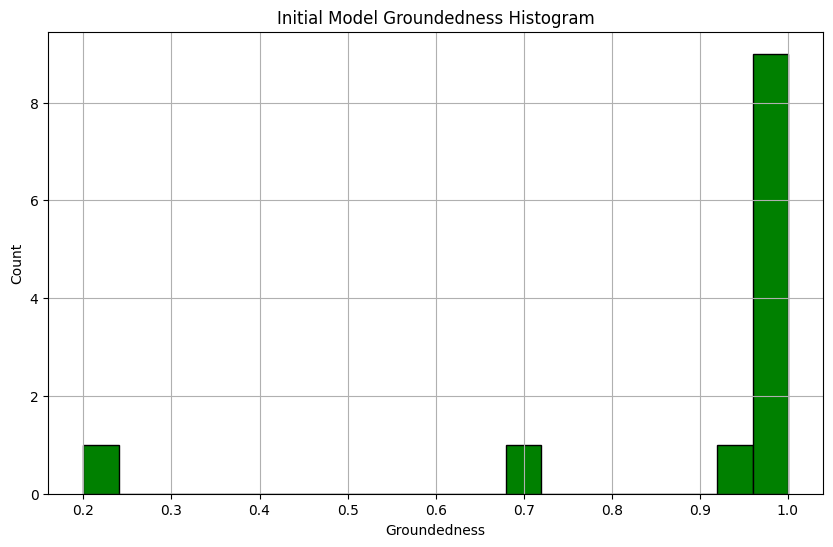

In [24]:
score_histogram(records1, 'Groundedness', 'Initial Model')

The model performs well in terms of Groundedness except for one question from the evaluation questions list. Let's see which question it is using the following code. 

The issue might be the limited number of test questions, which I prepared; with more questions, the results distribution could be more representative.

In [25]:
records1[records1['Groundedness'] <= 0.2]

,app_id,app_json,type,record_id,input,output,tags,record_json,cost_json,perf_json,ts,Answer Relevance,Context Relevance,Groundedness,Answer Relevance_calls,Context Relevance_calls,Groundedness_calls,latency,total_tokens,total_cost
1,Direct Query Engine,"{""tru_class_info"": {""name"": ""TruLlama"", ""modul...",RetrieverQueryEngine(llama_index.core.query_en...,record_hash_f91f1c0fa44c00ae205f9ff3a699fa57,"""Databricks: How to Save Data Frames as CSV Fi...","""To save data frames from Databricks into CSV ...",-,"{""record_id"": ""record_hash_f91f1c0fa44c00ae205...","{""n_requests"": 2, ""n_successful_requests"": 2, ...","{""start_time"": ""2024-04-09T00:45:19.916258"", ""...",2024-04-09T00:45:27.584021,0.9,0.325,0.2,[{'args': {'prompt': 'Databricks: How to Save ...,[{'args': {'prompt': 'Databricks: How to Save ...,[{'args': {'source': 'Databricks: How to Save ...,7,3006,0.004547


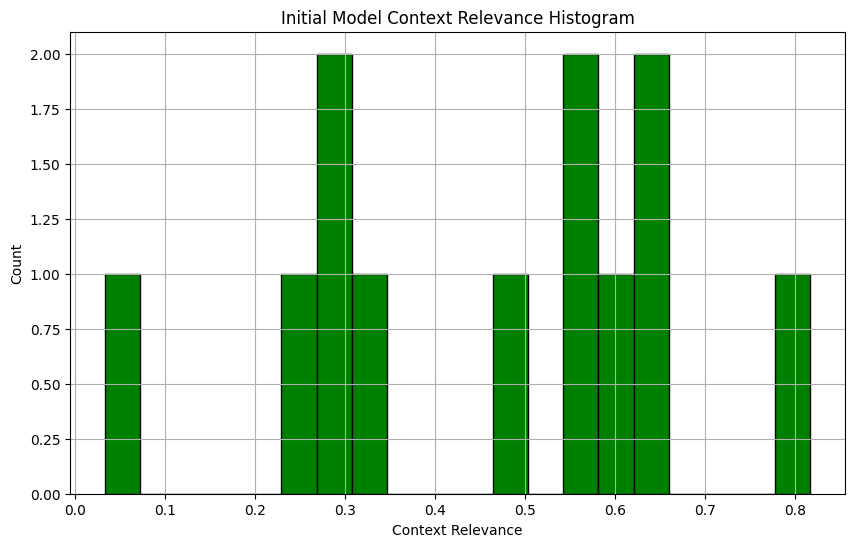

In [21]:
score_histogram(records1, 'Context Relevance', 'Initial Model')

As can be seen on the histogram above this model has much worse Context Relevance than Groundedness in most cases. 

Again, I displayed the query with an exceptionally low score, and I will be doing the same for other models in the further part of the notebook.

In [26]:
records1[records1['Context Relevance'] <= 0.1]

,app_id,app_json,type,record_id,input,output,tags,record_json,cost_json,perf_json,ts,Answer Relevance,Context Relevance,Groundedness,Answer Relevance_calls,Context Relevance_calls,Groundedness_calls,latency,total_tokens,total_cost
6,Direct Query Engine,"{""tru_class_info"": {""name"": ""TruLlama"", ""modul...",RetrieverQueryEngine(llama_index.core.query_en...,record_hash_6074d4d5089436df25736ecd8b6d1765,"""What are 4 main types of hackathons?""","""The four main types of hackathons are Data Sc...",-,"{""record_id"": ""record_hash_6074d4d5089436df257...","{""n_requests"": 2, ""n_successful_requests"": 2, ...","{""start_time"": ""2024-04-09T00:46:00.288127"", ""...",2024-04-09T00:46:06.725460,1.0,0.033333,1.0,[{'args': {'prompt': 'What are 4 main types of...,[{'args': {'prompt': 'What are 4 main types of...,[{'args': {'source': '3 Essential Persons Need...,6,3227,0.004841


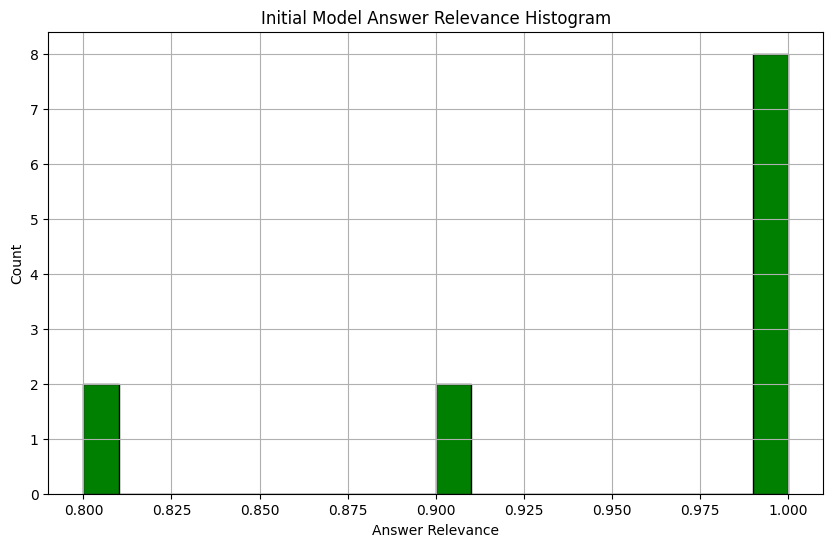

In [20]:
score_histogram(records1, 'Answer Relevance', 'Initial Model')

The model exhibited remarkable Answer Relevance, indicating its effectiveness in addressing the given query.

Model Summary

In [23]:
tru.get_leaderboard(app_ids=[])

,Groundedness,Answer Relevance,Context Relevance,latency,total_cost
app_id,,,,,
Direct Query Engine,0.902778,0.95,0.456944,7.0,0.004673


I was able to create a RAG model, which efficiently retrieves data from the index. Model has great Answer Relevance and Groundedness. However, Context Relevance is low, meaning that the retrieved context may contain irrelevant information, potentially leading to hallucinations or inaccurate responses. 

Model had problems with questions: _'Databricks: How to Save Data Frames as CSV Files on Your Local Computer?'_,  _'What are 4 main types of hackathons?'_.

## Sentence Window Model

Second model implements Sentence Window Retrieval, which enhances context extraction by considering a window of sentences rather than individual sentences. Configuring the window size was the most significant change in the ingestion pipeline. Additionally, I implemented reranking functionality to refine the retrieval results and ensure better contextual relevance for subsequent processing. By broadening the retrieval scope, the model gains access to a wider context, facilitating the generation of more accurate and contextually relevant responses (image below). As a result, the model can capture long-range dependencies and nuances in the given prompt, leading to improved overall performance.

<p align="center">
  <img src="../images/sentence_window_schema.png" alt="Sentence Window">
</p>


Model can be adjusted by changing the _'top_k'_ parameter.

In [27]:
senetnce_window_model = SentenceWindowRagModel(df, top_k=6)
senetnce_window_model.create_engine()

The model's response to the prompt is longer compared to the initial model. However, the model retrieved the context from the correct fragment while rephrasing some words.

In [28]:
str(senetnce_window_model.engine.query(sample_question))

'According to the Neuron Doctrine, the neuron is considered the fundamental structural and functional unit of the brain. Neurons transmit information to other neurons through electrical impulses that travel from dendrites to axon via the cell body. Maintaining an ionic potential difference between the inside and outside of the neuron requires a significant amount of daily glucose consumption. The myelin sheath plays a crucial role in facilitating fast and lossless long-distance communication of electrical impulses by wrapping around the axon.'

In [29]:
tru.reset_database()

In [30]:
tru_recorder_sentence_window = get_prebuilt_trulens_recorder(
    senetnce_window_model.engine,
    app_id = "Sentence Window Query Engine"
)

In [ ]:
for question in eval_questions:
    with tru_recorder_sentence_window as recording:
        response = senetnce_window_model.engine.query(question)

In [32]:
records2, feedback = tru.get_records_and_feedback(app_ids=[])

In [33]:
records2.head()

,app_id,app_json,type,record_id,input,output,tags,record_json,cost_json,perf_json,ts,Answer Relevance,Context Relevance,Groundedness,Answer Relevance_calls,Context Relevance_calls,Groundedness_calls,latency,total_tokens,total_cost
0,Sentence Window Query Engine,"{""tru_class_info"": {""name"": ""TruLlama"", ""modul...",RetrieverQueryEngine(llama_index.core.query_en...,record_hash_f564986ccb541c455f1c54c21d1df003,"""What is Word2vec?""","""Word2vec is a popular technique used to learn...",-,"{""record_id"": ""record_hash_f564986ccb541c455f1...","{""n_requests"": 1, ""n_successful_requests"": 1, ...","{""start_time"": ""2024-04-09T01:04:12.891850"", ""...",2024-04-09T01:04:23.017966,0.9,0.90,1.000000,"[{'args': {'prompt': 'What is Word2vec?', 'res...","[{'args': {'prompt': 'What is Word2vec?', 'res...",[{'args': {'source': 'A Beginner’s Guide to Wo...,10,484,0.000768
1,Sentence Window Query Engine,"{""tru_class_info"": {""name"": ""TruLlama"", ""modul...",RetrieverQueryEngine(llama_index.core.query_en...,record_hash_5a8a926546079ccfd5bbd5c2a46f1649,"""Databricks: How to Save Data Frames as CSV Fi...","""To save data frames from Databricks into CSV ...",-,"{""record_id"": ""record_hash_5a8a926546079ccfd5b...","{""n_requests"": 1, ""n_successful_requests"": 1, ...","{""start_time"": ""2024-04-09T01:04:23.453620"", ""...",2024-04-09T01:04:36.286194,0.9,0.80,0.833333,[{'args': {'prompt': 'Databricks: How to Save ...,[{'args': {'prompt': 'Databricks: How to Save ...,[{'args': {'source': 'Databricks is a Microsof...,12,567,0.000888
2,Sentence Window Query Engine,"{""tru_class_info"": {""name"": ""TruLlama"", ""modul...",RetrieverQueryEngine(llama_index.core.query_en...,record_hash_31879f48cc60c5c5c9d576c854208671,"""What is What-If Tool?""","""The What-If Tool is a tool designed for speed...",-,"{""record_id"": ""record_hash_31879f48cc60c5c5c9d...","{""n_requests"": 1, ""n_successful_requests"": 1, ...","{""start_time"": ""2024-04-09T01:04:36.701661"", ""...",2024-04-09T01:04:46.959100,0.9,0.50,0.900000,"[{'args': {'prompt': 'What is What-If Tool?', ...","[{'args': {'prompt': 'What is What-If Tool?', ...",[{'args': {'source': 'Analytics is not about p...,10,547,0.000862
3,Sentence Window Query Engine,"{""tru_class_info"": {""name"": ""TruLlama"", ""modul...",RetrieverQueryEngine(llama_index.core.query_en...,record_hash_ed030c05598a409361ad9c4a6b7ea3b5,"""Transfer Learning?""","""Transfer learning involves utilizing pre-exis...",-,"{""record_id"": ""record_hash_ed030c05598a409361a...","{""n_requests"": 1, ""n_successful_requests"": 1, ...","{""start_time"": ""2024-04-09T01:04:47.376947"", ""...",2024-04-09T01:04:57.249051,1.0,0.95,1.000000,"[{'args': {'prompt': 'Transfer Learning?', 're...","[{'args': {'prompt': 'Transfer Learning?', 're...",[{'args': {'source': 'Transfer Learning. The ...,9,397,0.000623
4,Sentence Window Query Engine,"{""tru_class_info"": {""name"": ""TruLlama"", ""modul...",RetrieverQueryEngine(llama_index.core.query_en...,record_hash_0480cee1e586229bde9ab52d41eb3fff,"""Neural Turing Machines?""","""Neural Turing Machines are designed with an a...",-,"{""record_id"": ""record_hash_0480cee1e586229bde9...","{""n_requests"": 1, ""n_successful_requests"": 1, ...","{""start_time"": ""2024-04-09T01:04:57.674984"", ""...",2024-04-09T01:05:07.779567,1.0,0.80,0.900000,[{'args': {'prompt': 'Neural Turing Machines?'...,[{'args': {'prompt': 'Neural Turing Machines?'...,[{'args': {'source': 'There is an activation f...,10,570,0.000881


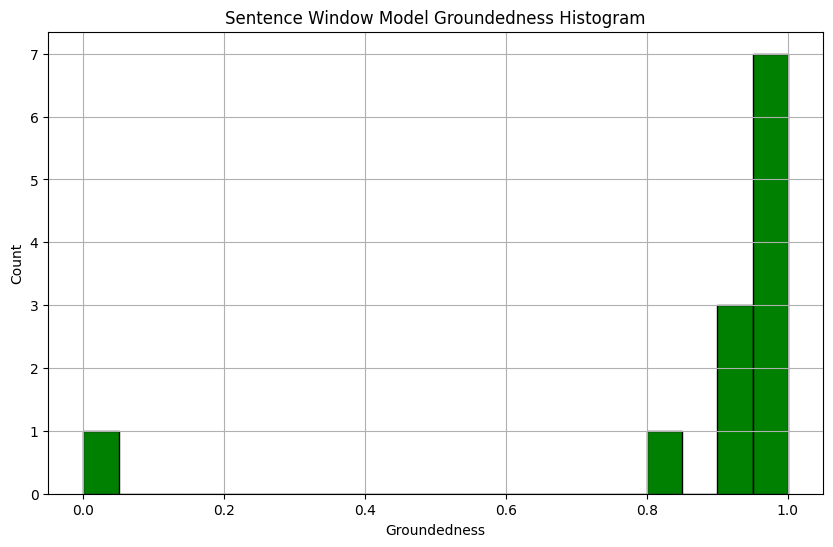

In [34]:
score_histogram(records2, 'Groundedness', 'Sentence Window Model')

The Sentence Window Model achieved perfect Groundedness scores in as many as 7 cases, but in one question, it yielded a dismal score of 0.0.

In [38]:
records2[records2['Groundedness'] <= 0.1]

,app_id,app_json,type,record_id,input,output,tags,record_json,cost_json,perf_json,ts,Answer Relevance,Context Relevance,Groundedness,Answer Relevance_calls,Context Relevance_calls,Groundedness_calls,latency,total_tokens,total_cost
6,Sentence Window Query Engine,"{""tru_class_info"": {""name"": ""TruLlama"", ""modul...",RetrieverQueryEngine(llama_index.core.query_en...,record_hash_068dacc54781771c017283ba4fc5c235,"""What are 4 main types of hackathons?""","""The four main types of hackathons are not exp...",-,"{""record_id"": ""record_hash_068dacc54781771c017...","{""n_requests"": 1, ""n_successful_requests"": 1, ...","{""start_time"": ""2024-04-09T01:05:18.412824"", ""...",2024-04-09T01:05:27.402490,1.0,0.2,0.0,[{'args': {'prompt': 'What are 4 main types of...,[{'args': {'prompt': 'What are 4 main types of...,[{'args': {'source': 'As hackathon is a very d...,8,447,0.000679


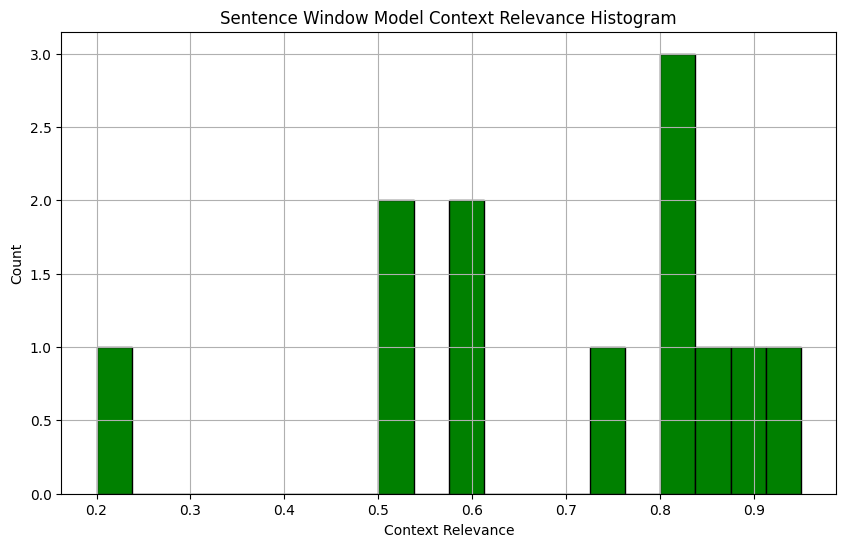

In [36]:
score_histogram(records2, 'Context Relevance', 'Sentence Window Model')

For this model, Context Relevance also exhibits lower values than Groundedness. However, they are notably higher than in the Initial Model. 

In [37]:
records2[records2['Context Relevance'] <= 0.2]

,app_id,app_json,type,record_id,input,output,tags,record_json,cost_json,perf_json,ts,Answer Relevance,Context Relevance,Groundedness,Answer Relevance_calls,Context Relevance_calls,Groundedness_calls,latency,total_tokens,total_cost
6,Sentence Window Query Engine,"{""tru_class_info"": {""name"": ""TruLlama"", ""modul...",RetrieverQueryEngine(llama_index.core.query_en...,record_hash_068dacc54781771c017283ba4fc5c235,"""What are 4 main types of hackathons?""","""The four main types of hackathons are not exp...",-,"{""record_id"": ""record_hash_068dacc54781771c017...","{""n_requests"": 1, ""n_successful_requests"": 1, ...","{""start_time"": ""2024-04-09T01:05:18.412824"", ""...",2024-04-09T01:05:27.402490,1.0,0.2,0.0,[{'args': {'prompt': 'What are 4 main types of...,[{'args': {'prompt': 'What are 4 main types of...,[{'args': {'source': 'As hackathon is a very d...,8,447,0.000679


As can be seen above Sentence Window Model has low both Groundedness and Context Relevance for the same question: _'What are 4 main types of hackathons?'_.

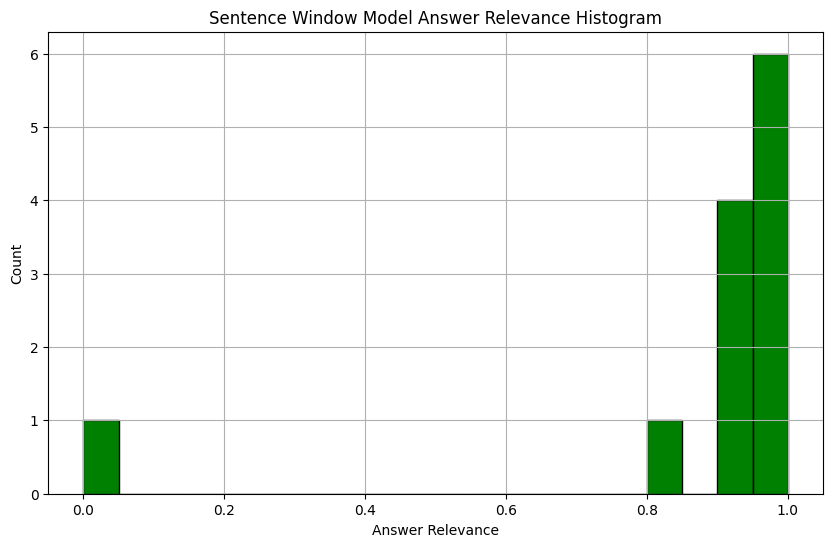

In [39]:
score_histogram(records2, 'Answer Relevance', 'Sentence Window Model')

In the Answer Relevance histogram, we can also see that the model performs very well except for one sentence.

In [40]:
records2[records2['Answer Relevance'] <= 0.1]

,app_id,app_json,type,record_id,input,output,tags,record_json,cost_json,perf_json,ts,Answer Relevance,Context Relevance,Groundedness,Answer Relevance_calls,Context Relevance_calls,Groundedness_calls,latency,total_tokens,total_cost
5,Sentence Window Query Engine,"{""tru_class_info"": {""name"": ""TruLlama"", ""modul...",RetrieverQueryEngine(llama_index.core.query_en...,record_hash_8ae94ea6d5c3af4a434621b857b2a181,"""Do human beings have the most densely packed ...","""Yes.""",-,"{""record_id"": ""record_hash_8ae94ea6d5c3af4a434...","{""n_requests"": 1, ""n_successful_requests"": 1, ...","{""start_time"": ""2024-04-09T01:05:08.196891"", ""...",2024-04-09T01:05:17.996964,0.0,0.5,1.0,[{'args': {'prompt': 'Do human beings have the...,[{'args': {'prompt': 'Do human beings have the...,[{'args': {'source': 'Brain: A Mystery “The mo...,9,467,0.000702


Model Summary

In [41]:
tru.get_leaderboard(app_ids=[])

,Groundedness,Answer Relevance,Context Relevance,latency,total_cost
app_id,,,,,
Sentence Window Query Engine,0.880556,0.866667,0.6875,9.833333,0.000768


The Sentence Window Model yielded notably disparate results compared to the Initial Model. It exhibited decreased scores in terms of Groundedness and Answer Relevance, contrasting with a remarkable 23 percentage-point increase in Context Relevance. Additionally, the total cost has substantially decreased, which is highly promising. However, there is an increase in Latency, which may cause challenges depending on the specific use case.

This Model also encountred problems answering to some questions: _'What are 4 main types of hackathons?'_, _'Do human beings have the most densely packed set of neurons?'_.

## Auto Merging Retrieval Model

I developed another solution using Auto Merging Retrieval, which works like:
- Initially, it divides the document into numerous chunks
- It divides the "parent" chunks into smaller "child" chunks
- During the querying process, it begins by retrieving smaller chunks based on embedding similarity.
- If the majority of these subset chunks are chosen based on embedding similarity, the parent chunk is returned; otherwise, only the selected child chunks are returned.

Auto Merging Retrieval merges similar chunks together, streamlining the retrieval process and enhancing overall efficiency. It also improves retrieval accuracy over time by refining the selection of chunks with similar embeddings. I added reranking functionality in this model too.

<p align="center">
  <img src="../images/automerging_retrieval.jpg" alt="Auto Merge">
</p>

Model can be adjusted by changing the _'top_k'_ parameter.

In [42]:
automerge_model = AutomergeRagModel(df, top_k=10)
automerge_model.create_engine()

This model also managed to respond to this question effectively.

In [43]:
str(automerge_model.engine.query(sample_question))

> Merging 1 nodes into parent node.
> Parent node id: 6fc7dc22-066e-4d9c-8702-fce98f05be4c.
> Parent node text: While artificial neurons do not have any such capability, any n-bit temporal pattern can be equal...



'The neuron is considered the fundamental structural and functional unit of the brain according to the Neuron Doctrine.'

In [44]:
tru.reset_database()

In [45]:
tru_recorder_automerging = get_prebuilt_trulens_recorder(automerge_model.engine,
                                             app_id="Automerging Query Engine")

In [ ]:
for question in eval_questions:
    with tru_recorder_automerging as recording:
        response = automerge_model.engine.query(question)

In [47]:
records3, feedback = tru.get_records_and_feedback(app_ids=[])

In [48]:
records3.head()

,app_id,app_json,type,record_id,input,output,tags,record_json,cost_json,perf_json,ts,Answer Relevance,Context Relevance,Groundedness,Answer Relevance_calls,Context Relevance_calls,Groundedness_calls,latency,total_tokens,total_cost
0,Automerging Query Engine,"{""tru_class_info"": {""name"": ""TruLlama"", ""modul...",RetrieverQueryEngine(llama_index.core.query_en...,record_hash_286766f937f1acf188a9822efe3e6751,"""What is Word2vec?""","""Word2vec is a two-layer neural network that p...",-,"{""record_id"": ""record_hash_286766f937f1acf188a...","{""n_requests"": 1, ""n_successful_requests"": 1, ...","{""start_time"": ""2024-04-09T01:24:43.284253"", ""...",2024-04-09T01:24:52.394125,1.0,1.00,0.80,"[{'args': {'prompt': 'What is Word2vec?', 'res...","[{'args': {'prompt': 'What is Word2vec?', 'res...","[{'args': {'source': '1, 1, 0, 1, 0, 0, 1, 1, ...",9,418,0.000663
1,Automerging Query Engine,"{""tru_class_info"": {""name"": ""TruLlama"", ""modul...",RetrieverQueryEngine(llama_index.core.query_en...,record_hash_0df922f4adc8e33ef7d0ba58530621dd,"""Databricks: How to Save Data Frames as CSV Fi...","""To save data frames as CSV files on your loca...",-,"{""record_id"": ""record_hash_0df922f4adc8e33ef7d...","{""n_requests"": 1, ""n_successful_requests"": 1, ...","{""start_time"": ""2024-04-09T01:24:52.912566"", ""...",2024-04-09T01:25:08.393236,1.0,0.90,0.60,[{'args': {'prompt': 'Databricks: How to Save ...,[{'args': {'prompt': 'Databricks: How to Save ...,[{'args': {'source': 'Databricks: How to Save ...,15,791,0.001259
2,Automerging Query Engine,"{""tru_class_info"": {""name"": ""TruLlama"", ""modul...",RetrieverQueryEngine(llama_index.core.query_en...,record_hash_f0ceb53fadf7c440b61419e382620d30,"""What is What-If Tool?""","""The What-If Tool is a tool designed for speed...",-,"{""record_id"": ""record_hash_f0ceb53fadf7c440b61...","{""n_requests"": 1, ""n_successful_requests"": 1, ...","{""start_time"": ""2024-04-09T01:25:08.916258"", ""...",2024-04-09T01:25:25.116522,0.8,0.50,0.65,"[{'args': {'prompt': 'What is What-If Tool?', ...","[{'args': {'prompt': 'What is What-If Tool?', ...","[{'args': {'source': 'Instead, it’ll help you ...",16,407,0.000637
3,Automerging Query Engine,"{""tru_class_info"": {""name"": ""TruLlama"", ""modul...",RetrieverQueryEngine(llama_index.core.query_en...,record_hash_24d1fd46d633c83490e5efebcaab5653,"""Transfer Learning?""","""Transfer Learning is a method that involves u...",-,"{""record_id"": ""record_hash_24d1fd46d633c83490e...","{""n_requests"": 1, ""n_successful_requests"": 1, ...","{""start_time"": ""2024-04-09T01:25:25.649734"", ""...",2024-04-09T01:25:42.201958,1.0,0.95,1.00,"[{'args': {'prompt': 'Transfer Learning?', 're...","[{'args': {'prompt': 'Transfer Learning?', 're...",[{'args': {'source': 'Transfer Learning. The p...,16,392,0.000617
4,Automerging Query Engine,"{""tru_class_info"": {""name"": ""TruLlama"", ""modul...",RetrieverQueryEngine(llama_index.core.query_en...,record_hash_f91f281fb6d8fe1bf0fb85ff99dda942,"""Neural Turing Machines?""","""Neural Turing Machines are designed with an a...",-,"{""record_id"": ""record_hash_f91f281fb6d8fe1bf0f...","{""n_requests"": 1, ""n_successful_requests"": 1, ...","{""start_time"": ""2024-04-09T01:25:42.711398"", ""...",2024-04-09T01:25:52.370403,1.0,0.60,0.90,[{'args': {'prompt': 'Neural Turing Machines?'...,[{'args': {'prompt': 'Neural Turing Machines?'...,[{'args': {'source': 'Neural Turing Machines ...,9,364,0.000575


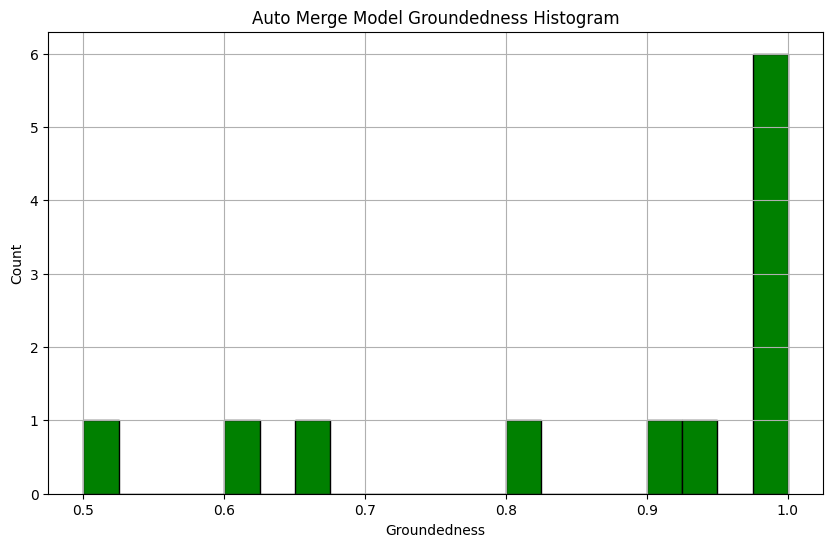

In [49]:
score_histogram(records3, 'Groundedness', 'Auto Merge Model')

The Auto Merge Model demonstrates decent Groundedness scores across all questions. Even though it has more results with scores below average, it doesn't have any catastrophic results (the lowest being 0.5).

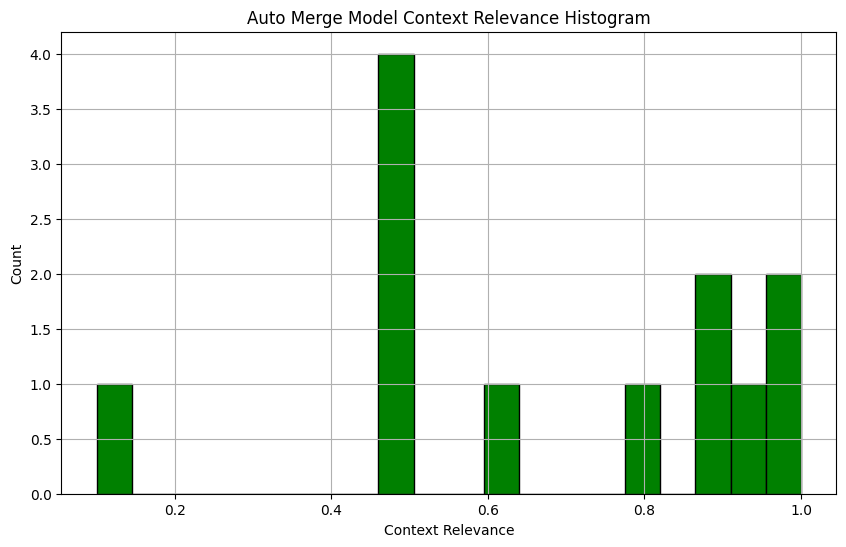

In [50]:
score_histogram(records3, 'Context Relevance', 'Auto Merge Model')

The model exhibits acceptable Context Relevance scores, but in one instance, it achieved only 0.1.

In [53]:
records3[records3['Context Relevance']<=0.2]

,app_id,app_json,type,record_id,input,output,tags,record_json,cost_json,perf_json,ts,Answer Relevance,Context Relevance,Groundedness,Answer Relevance_calls,Context Relevance_calls,Groundedness_calls,latency,total_tokens,total_cost
6,Automerging Query Engine,"{""tru_class_info"": {""name"": ""TruLlama"", ""modul...",RetrieverQueryEngine(llama_index.core.query_en...,record_hash_0ca519081bede75446fd5b0488058247,"""What are 4 main types of hackathons?""","""The four main types of hackathons are the one...",-,"{""record_id"": ""record_hash_0ca519081bede75446f...","{""n_requests"": 1, ""n_successful_requests"": 1, ...","{""start_time"": ""2024-04-09T01:26:02.607356"", ""...",2024-04-09T01:26:17.406776,1.0,0.1,1.0,[{'args': {'prompt': 'What are 4 main types of...,[{'args': {'prompt': 'What are 4 main types of...,[{'args': {'source': '3 Essential Persons Need...,14,693,0.001058


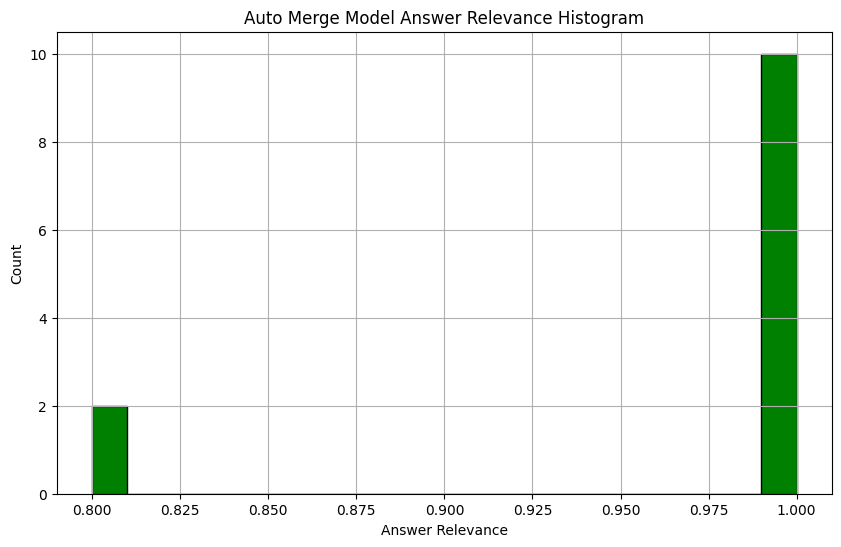

In [51]:
score_histogram(records3, 'Answer Relevance', 'Auto Merge Model')

The Auto Merge Model achieves very high scores in Answer Relevance, with perfect scores of 1.0 in as many as 10 cases.

Model Summary

In [52]:
tru.get_leaderboard(app_ids=[])

,Groundedness,Answer Relevance,Context Relevance,latency,total_cost
app_id,,,,,
Automerging Query Engine,0.865278,0.966667,0.6875,12.25,0.000734


This model has the best Answer Relevance and satisfactory Context Relevance. Nevertheless, its Groundedness is the lowest compared to other models. It's worth mentioning that it also exhibits the highest Latency, which can lead to delays in response times. The total cost remains more or less the same as the Sentence Window Model.

## Bonus: Context Chat Model

Lastly I decieded to create RAG model by utilizing context chat engine from LlamaIndex. The approach is straightforward: we establish an index same as in other models, and then we provide the chat engine with a context that guides its behavior according to the context. For this model I used the most simplified indexing strategy using Vector Store Index without adjusting any parameters.

In [25]:
context = "Your sole purpose is to retrieve relevant excerpts from '1300 Towards Data Science Medium Articles' without any alterations. You must strictly adhere to preserving the exact wording of the source material and refrain from any form of interpretation or elaboration. Do NOT use any previous knowledge about Data Science and related topics."

In [26]:
chat_rag_model = ChatRagModel(df, context)

The chat response appears to be identical to content found in one of the articles from the '1300 Towards Data Science Medium Articles' dataset.

**Original Fragment**: According to the Neuron Doctrine, the neuron is the fundamental structural and functional unit of the brain. Neurons pass information to other neurons in the form of electrical impulses from dendrites to axon via cell body. 

In [27]:
chat_rag_model.create_engine()
chat_rag_model.interact()

According to the Neuron Doctrine, the neuron is the fundamental structural and functional unit of the brain. Neurons pass information to other neurons in the form of electrical impulses from dendrites to axon via cell body.


In [33]:
for question in eval_questions:
    response = chat_rag_model.engine.chat(question)
    print(f"Question: {question}")
    print(f"Response: {response}\n")

Question: What is Word2vec?
Response: Word2vec is a technique used to learn word embeddings through a two-layer neural network. It takes a text corpus as input and generates a set of vectors as output, representing words in that corpus. The algorithm was developed by Google in 2013 and can be visualized in a multi-dimensional space.

Question: Databricks: How to Save Data Frames as CSV Files on Your Local Computer?
Response: To save data frames from Databricks into CSV format on your local computer, you can follow these steps:

1. Explore the Databricks File System (DBFS) by going to “Upload Data” (under Common Tasks) → “DBFS” → “FileStore”.

2. Save a data frame into CSV in FileStore using the following code on the notebook:
Sample.coalesce(1).write.format(“com.databricks.spark.csv”).option(“header”, “true”).save(“dbfs:/FileStore/df/Sample.csv”)

Make sure to include coalesce(1) in the code to save the data frame as a whole.

Question: What is What-If Tool?
Response: The What-If Tool 

I couldn't directly compare this model to others using the RAG Triad metrics. However, considering the responses from the evaluation questions, it's evident that this model also excels in retrieving information. The answers we're getting seem like they're copy-paste from the dataset articles, which shows the model's really good at finding the right info. Given its very simple indexing strategy, it can be considered among the best performers.

## Models Comparison 

In order to decide which model is the best I decied to visulize their results by utilizing boxplots.

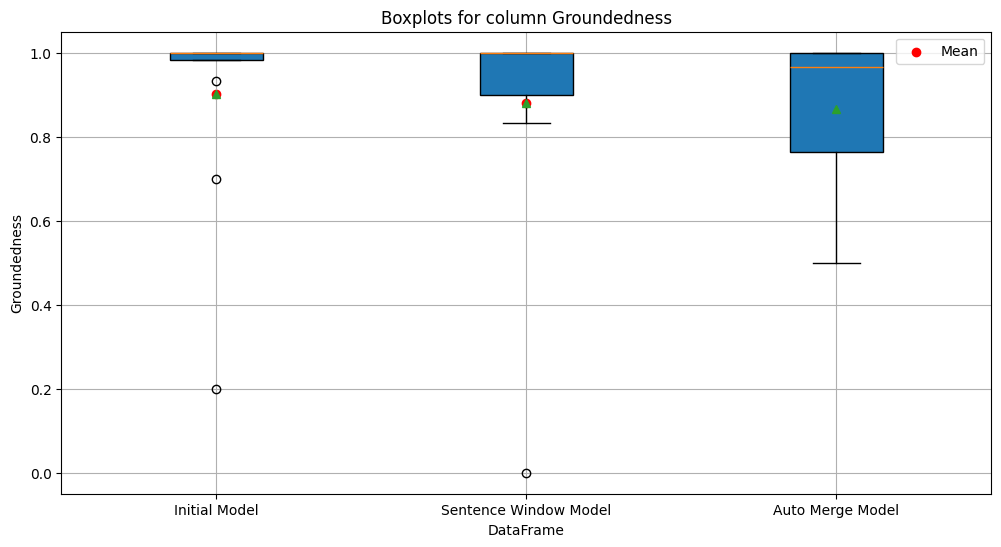

In [54]:
score_boxplot(records1, records2, records3 , 'Groundedness') 	

On the chart above, we can see that the Initial Model outperforms the others in terms of Groundedness score. If we were to exclude outlier points, it would have an even greater advantage. The second one is the Sentence Window Model, which, except for one question, performed admirably. Lastly, the Auto Merge Model, despite scoring lower compared to others, stil has decent Groundedness also has the highest outlier value among all models, which may indicate that it is more resistant to outliers.

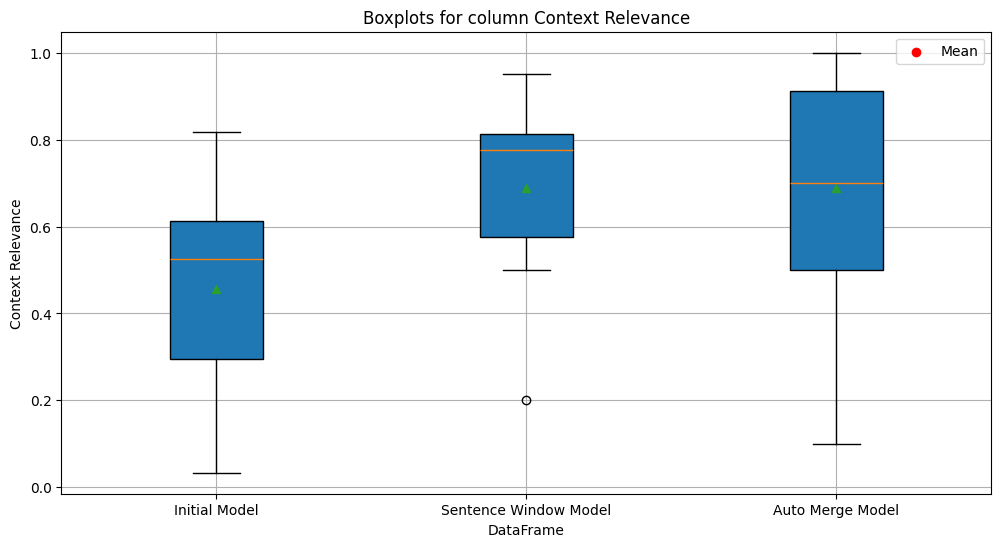

In [55]:
score_boxplot(records1, records2, records3 , 'Context Relevance')

In the case of Context Relevance, we can observe that the Initial Model performed noticeably the worst. Comparing the Sentence Window Model and the Auto Merge Model, we can see that the distribution of results for the former is more consistent. Additionally, we can see that these models have equal means, but the Sentence Window Model has a higher median.

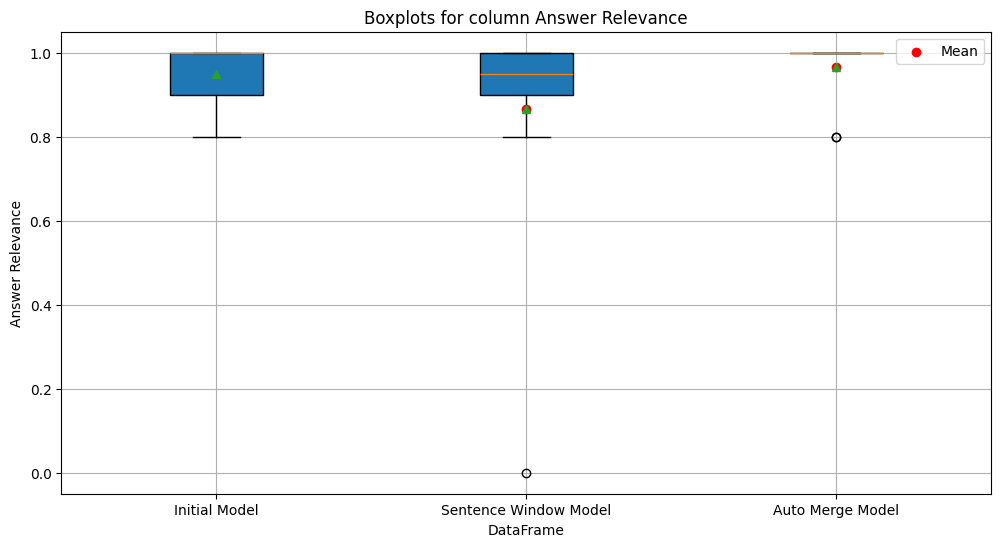

In [56]:
score_boxplot(records1, records2, records3 , 'Answer Relevance')

The Auto Merge model definitely has the best Answer Relevance due to a significant margin. The Initial Model achieves only slightly better results than the Sentence Window Model.

## Conclusion


I've developed 4 distinct RAG models, each showcasing unique advantages and drawbacks. It's challenging to determine which model is the best.

Each model has its own strengths and weaknesses. Personally, I would first dismiss the Initial Model because it has too low Context Relevance. A low score in this metric suggests that the model may not effectively retrieve chunks related to the query. The other models, which are enriched with algorithms for expanded context retrival, show significantly higher scores in this metric. Despite having lower scores in other metrics (which can be considered a trade-off), they perform better in terms of Context Relevance.

In my opinion, the better model between the Sentence Window Model and the Auto Merge Model is the former. It exhibits more stable results in terms of Context Relevance and Groundedness. However, the Auto Merge Model is also excellent, as evidenced by its impressive Answer Relevance score.